In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lasio
import pywt
from fastdtw import fastdtw
from scipy import linalg, signal, fft, interpolate, stats, spatial, special
from sklearn.preprocessing import MinMaxScaler

def plot_curve(ax, df, curve, lb=None, ub=None, color='k', pad=0, s=2, mult=1,
            units:str=None, mask=None, offset:int=0, title:str=None, subtitle:str=None,
            label:str=None, semilog:bool=False, bar:bool=False, 
            fill:bool=None, rightfill:bool=False,
            marker=None, edgecolor=None, ls=None, alpha=None):
        if mask is None:
            x, y = -offset+mult*df[curve], df.index
        else:
            x, y = -offset+mult*df[curve][mask], df.index[mask]
        lb = x[~np.isnan(x)].min() if lb is None else lb
        ub = x[~np.isnan(x)].max() if ub is None else ub
        if semilog:
            ax.semilogx(x, y, c=color, label=curve, alpha=alpha,
                        marker=marker, markersize=s, markeredgecolor=edgecolor, linestyle=ls, linewidth=s)
        else:
            if bar:
                ax.barh(y, x, color=color, label=curve, alpha=alpha)
            else:
                ax.plot(x, y, c=color, label=curve, alpha=alpha,
                        marker=marker, markersize=s, markeredgecolor=edgecolor, linewidth=s, linestyle=ls)
        if fill:
            if rightfill:
                ax.fill_betweenx(y, x, ub, alpha=alpha, color=color)
            else:
                ax.fill_betweenx(y, lb, x, alpha=alpha, color=color)
        if units is None:
            if hasattr(df, 'curvesdict'):
                units = df.curvesdict[curve].unit
            else:
                units = ''
        ax.set_xlim(lb, ub)
        ax.grid(True, which='both')
        ax.set_title(title, weight='bold') if title != None else None
        xlab = label if label is not None else curve
        if offset != 0:
            ax.set_xlabel('{} [{}] with {} offset'.format(xlab, units, offset), color=color, weight='bold')
        else:
            ax.set_xlabel('{} [{}]'.format(xlab, units), color=color, weight='bold')
        ax.xaxis.set_label_position('top'); ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_tick_params(color=color, width=s)
        ax.spines['top'].set_position(('axes', 1+pad/100))
        ax.spines['top'].set_edgecolor(color); ax.spines['top'].set_linewidth(2)
        if subtitle is not None:
            ax.text(0.5, 0.01, subtitle, verticalalignment='bottom', horizontalalignment='center',
                    transform=ax.transAxes, color='k', fontsize=8, weight='bold')
        if ls is not None:
            ax.spines['top'].set_linestyle(ls)
        return None

In [23]:
well1  = lasio.read('data/chevron2009.LAS').df()                                                                                                    # Chevron 2009 Egypt
well2  = lasio.read('data/akerbp.las').df()                                                                                                         # AkerBP 2016 Norway
well3  = lasio.read('data/3T-621_OH.LAS').df()                                                                                                      # ConocoPhillips Alaska 1
well4  = lasio.read('data/MORAINE 1_OH_DATA.LAS').df()                                                                                              # ConocoPhillips Alaska Moraine
well5  = lasio.read('data/Smeaheia/data/32 2-1').df().iloc[10:]                                                                                     # Smeaheia 32/2-1
well6  = lasio.read('data/Smeaheia/data/32 4-1').df()                                                                                               # Smeaheia 32/4-1
well7  = lasio.read('data/Sleipner/data/Wells_released_2011/Well 159_13/159-13 Logs.LAS').df()                                                      # Sleipner 15-9/13
well8  = lasio.read('data/Sleipner/data/Wells_released_2011/Well 159_A16/159-A-16.LAS').df()                                                        # Sleipner 15-9/A-16
well9  = lasio.read('data/Decatur/data/IBDP_Geophysical_Logs/1211523415_CCS1/Raw_Logs/1211523415_20200727_CCS1_Compiled_Raw_Logs_Petrel.LAS').df()  # Decatur CCS1
well10 = lasio.read('data/Utah Forge/Wireline Field Data/UnivUtah_Forge16A-78-32_R4_USI_MainPass.LAS').df()                                         # Utah Forge 16A-78-32
well11 = lasio.read('data/Cranfield/F1 Well Logs/las/06-06-09 APWH00103_DENBURY_CFU_31F_1_PEX_MLT_MAIN_009PUP-GenericV20.LAS').df()                 # Cranfield 31F-1
well12 = lasio.read("data/Cranfield/other-wells/48-1.LAS").df()                                                                                     # Cranfield 48-1

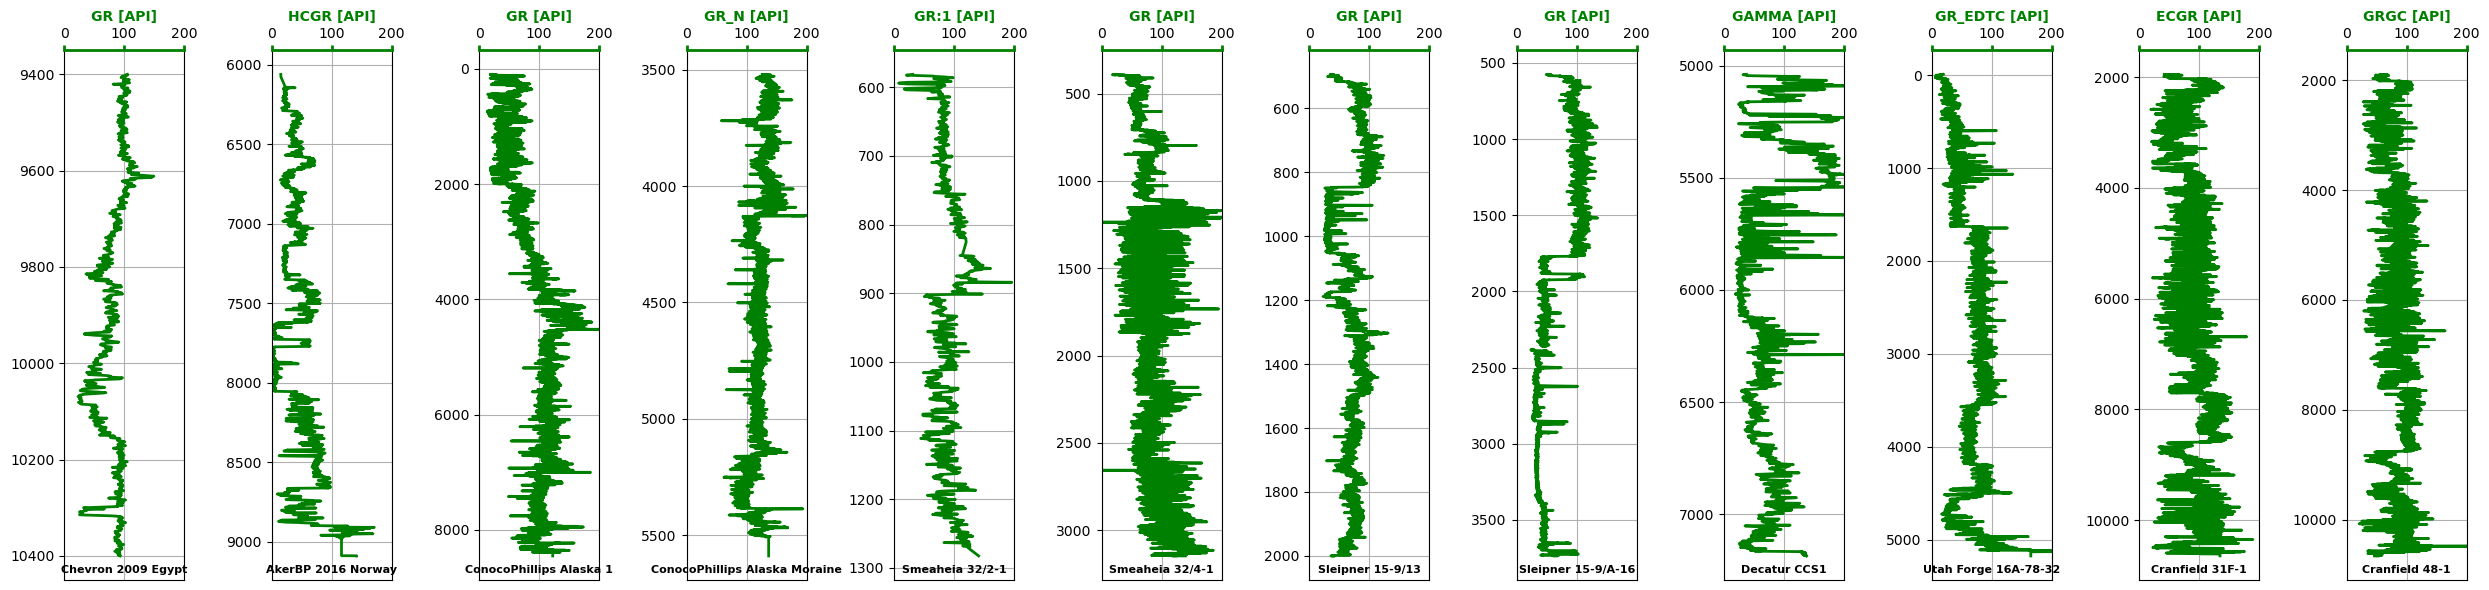

In [24]:
fig, axs = plt.subplots(1, 12, figsize=(25,6))
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12 = axs
glb, gub = 0, 200

plot_curve(ax1, well1, 'GR', lb=glb, ub=gub, color='g', units='API', subtitle='Chevron 2009 Egypt')
plot_curve(ax2, well2, 'HCGR', lb=glb, ub=gub, color='g', units='API', subtitle='AkerBP 2016 Norway')
plot_curve(ax3, well3, 'GR', lb=glb, ub=gub, color='g', units='API', subtitle='ConocoPhillips Alaska 1')
plot_curve(ax4, well4, 'GR_N', lb=glb, ub=gub, color='g', units='API', subtitle='ConocoPhillips Alaska Moraine')
plot_curve(ax5, well5, 'GR:1', lb=glb, ub=gub, color='g', units='API', subtitle='Smeaheia 32/2-1')
plot_curve(ax6, well6, 'GR', lb=glb, ub=gub, color='g', units='API', subtitle='Smeaheia 32/4-1')
plot_curve(ax7, well7, 'GR', lb=glb, ub=gub, color='g', units='API', subtitle='Sleipner 15-9/13')
plot_curve(ax8, well8, 'GR', lb=glb, ub=gub, color='g', units='API', subtitle='Sleipner 15-9/A-16')
plot_curve(ax9, well9, 'GAMMA', lb=glb, ub=gub, color='g', units='API', subtitle='Decatur CCS1')
plot_curve(ax10, well10, 'GR_EDTC', lb=glb, ub=gub, color='g', units='API', subtitle='Utah Forge 16A-78-32')
plot_curve(ax11, well11, 'ECGR', lb=glb, ub=gub, color='g', units='API', subtitle='Cranfield 31F-1')
plot_curve(ax12, well12, 'GRGC', lb=glb, ub=gub, color='g', units='API', subtitle='Cranfield 48-1')

[a.invert_yaxis() for a in axs]
plt.tight_layout()
plt.show()

In [418]:
def resample_signal(dd, new_size, kind='cubic'):
    dd = np.array(dd)
    x_old = np.linspace(0, 1, len(dd))
    x_new = np.linspace(0, 1, new_size)
    interpolator = interpolate.interp1d(x_old, dd.flatten(), kind=kind)
    return interpolator(x_new)

def log_pattern(dd, stencil, window_size, lag):
    dd = np.array(dd)
    dd = signal.medfilt(dd, kernel_size=3)
    # calculate moving windows
    windows = []
    for i in range(0, len(dd)-window_size+1, lag):
        w = dd[i:i+window_size]
        windows.append(w)
    windows = np.array(windows)
    windows_norm = MinMaxScaler().fit_transform(windows.T).T
    # calculate correlations
    stencil_norm = (stencil - stencil.min()) / (stencil.max() - stencil.min())
    stencil_long = resample_signal(stencil_norm, len(windows_norm[0]))
    correlations = []
    for i in range(len(windows)):
        corr = signal.correlate(windows_norm[i], stencil_norm, mode='same')
        conv = signal.convolve(windows_norm[i], stencil_norm, mode='same')
        rcor = np.abs(stats.pearsonr(windows_norm[i], stencil_long)[0])
        dist = spatial.distance.euclidean(windows_norm[i], stencil_long)
        #kl = special.kl_div(windows_norm[i], stencil_long)
        #dtw, path = fastdtw(windows_norm[i], stencil, dist=spatial.distance.euclidean)
        v = (corr + conv) /2
        correlations.append(v)
    correlations = np.array(correlations)
    # calculate similarity pattern
    similarity = np.zeros(dd.shape)
    count = np.zeros(dd.shape)
    for i in range(len(windows)):
        start_idx = i*lag
        similarity[start_idx:start_idx+window_size] += correlations[i]
        count[start_idx:start_idx+window_size] += 1
    similarity /= count
    similarity /= similarity.max()
    return similarity

ww: (8001,)
stencil: (253,)


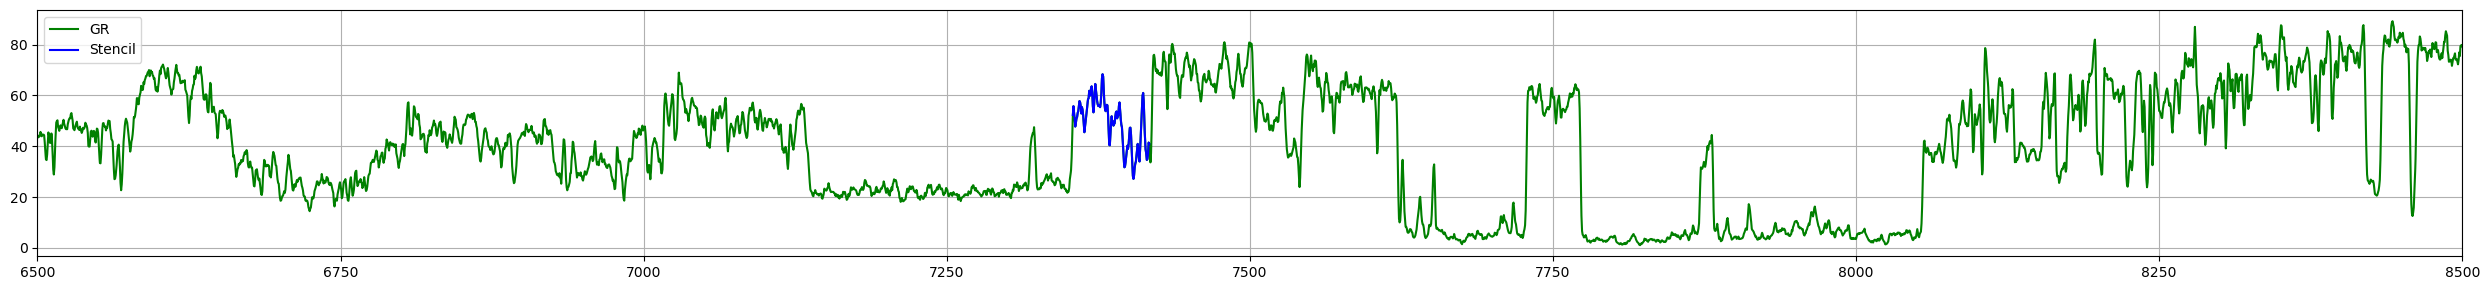

In [419]:
start, end = 6500, 8500
window_size = 63
p1 = 7354

ww = well2.loc[start:end]['HCGR']
print('ww: {}'.format(ww.shape))

stencil = ww.loc[p1:p1+window_size]
stencil_norm = (stencil - stencil.min()) / (stencil.max() - stencil.min())
print('stencil: {}'.format(stencil.shape))

plt.figure(figsize=(25,3))
plt.plot(ww.index, ww, c='g', label='GR')
plt.plot(stencil.index, stencil, c='b', label='Stencil')
plt.xlim(start, end)
plt.legend(loc='upper left')
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

In [420]:
window_sizes = [11, 51, 101, 151, 301]
similarity = []
for w in window_sizes:
    sim = log_pattern(ww, stencil, window_size=w, lag=5)
    similarity.append(sim)
similarity = np.mean(similarity, axis=0)

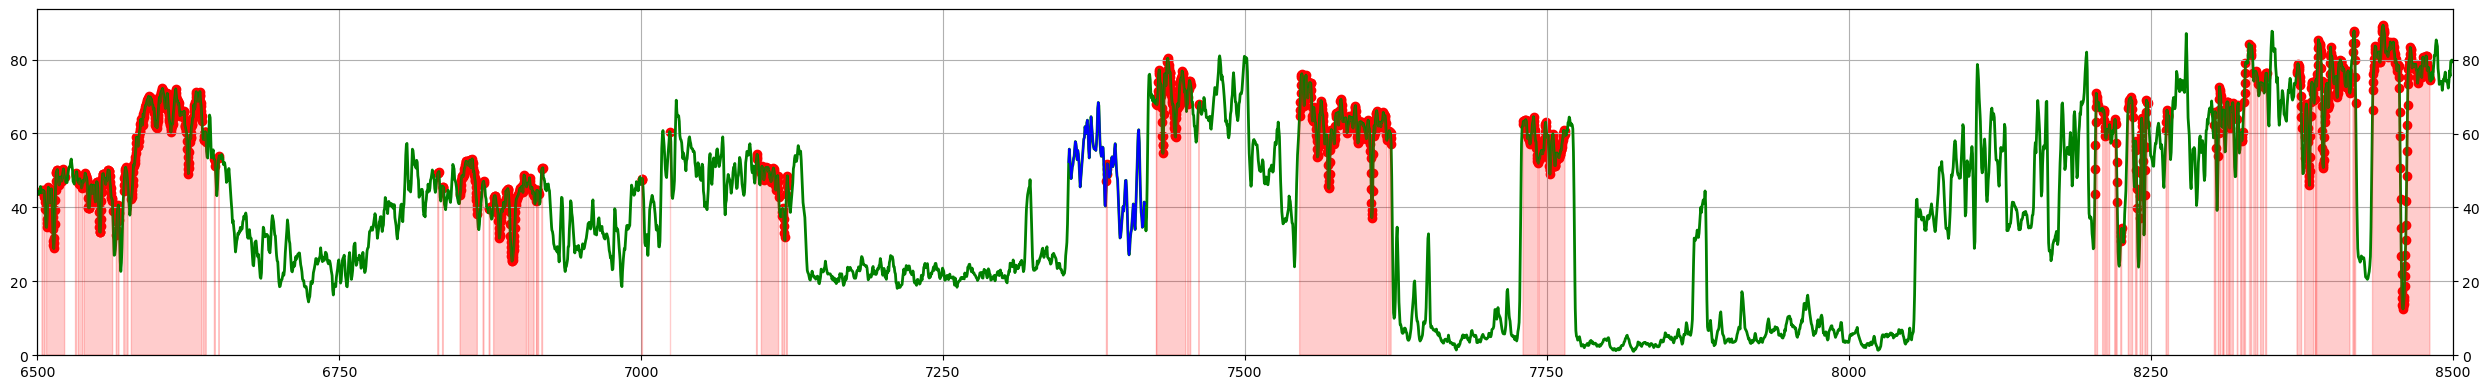

In [421]:
threshold = 0.7
similar_idx = np.argwhere(similarity > threshold).flatten()

fig = plt.figure(figsize=(25,4))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.plot(ww.index, ww, c='g', lw=2)
ax1.scatter(ww.index[similar_idx], ww.iloc[similar_idx], c='r', marker='o')
ax1.plot(stencil.index, stencil, c='b')
ax2.fill_between(ww.index, 0, ww, similarity>threshold, color='r', alpha=0.2)

ax1.grid(True, which='both')
ax1.set(xlim=(ww.index.min(), ww.index.max()), ylim=(0,None))
ax2.set(ylim=(0,None))
plt.tight_layout()
plt.show()

***
# END